Objective
This notebook analyzes the implied volatility surface generated by the Merton jump–diffusion model. Option prices produced by the jump model are inverted through the Black–Scholes formula to examine how jump risk manifests as volatility smiles and skews.

In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT))

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from src.option_pricing import merton_option_price_formula
from src.implied_volatility import implied_vol


In [3]:
S0 = 100.0
r = 0.05
T = 1.0

# Diffusion vol
sigma = 0.18

# Jump parameters
lam = 0.8
mu_J = -0.35
sigma_J = 0.25

Ks = np.linspace(70, 130, 25)


In [4]:
prices_merton = [
    merton_option_price_formula(
        S0, K, r, T,
        sigma=sigma,
        lam=lam,
        mu_J=mu_J,
        sigma_J=sigma_J,
        runs = 1000,
        option_type="call"
    )
    for K in Ks
]


In [5]:
iv_merton = [
    implied_vol(
        price=p,
        S0=S0,
        K=K,
        r=r,
        T=T,
        option_type="call"
    )
    for p, K in zip(prices_merton, Ks)
]


In [6]:
iv_bs = np.full_like(Ks, sigma)


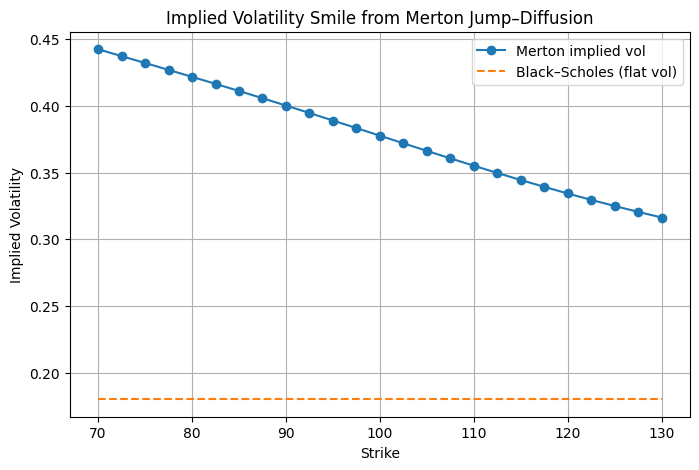

In [7]:
plt.figure(figsize=(8, 5))

plt.plot(Ks, iv_merton, marker="o", label="Merton implied vol")
plt.plot(Ks, iv_bs, linestyle="--", label="Black–Scholes (flat vol)")

plt.xlabel("Strike")
plt.ylabel("Implied Volatility")
plt.title("Implied Volatility Smile from Merton Jump–Diffusion")
plt.legend()
plt.grid(True)
plt.show()


The pronounced left skew in implied volatility mirrors the heavy downside tail observed in the return distribution and the elevated Conditional Value-at-Risk under the jump–diffusion model. While Value-at-Risk shows limited sensitivity to rare jumps, option prices—being convex payoffs—are highly sensitive to tail risk, leading to substantial distortions in implied volatility space.

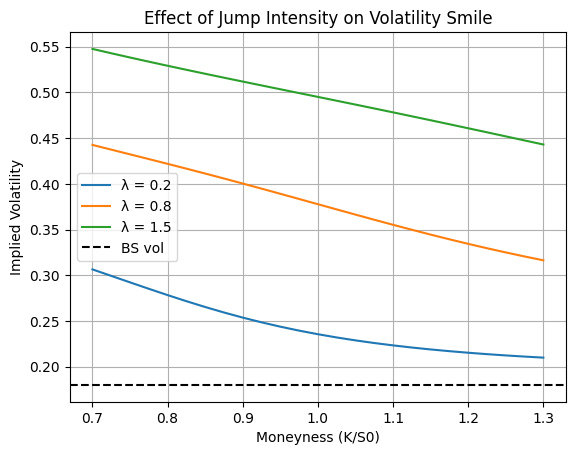

In [9]:
for lam_test in [0.2, 0.8, 1.5]:
    prices = [
        merton_option_price_formula(S0, K, r, T, sigma=sigma, lam=lam_test, mu_J=mu_J, sigma_J=sigma_J,runs = 2000)
        for K in Ks
    ]
    ivs = [implied_vol(p, S0, K, r, T) for p, K in zip(prices, Ks)]
    plt.plot(Ks/S0, ivs, label=f"λ = {lam_test}")

plt.axhline(sigma, linestyle="--", color="black", label="BS vol")
plt.xlabel("Moneyness (K/S0)")
plt.ylabel("Implied Volatility")
plt.title("Effect of Jump Intensity on Volatility Smile")
plt.legend()
plt.grid(True)
plt.show()


Increasing jump intensity raises implied volatility across all strikes and steepens the volatility skew. While diffusion volatility remains fixed, more frequent jumps increase the probability of extreme price movements, particularly on the downside. This additional tail risk is reflected in higher implied volatilities, especially for low strikes, consistent with the elevated Conditional Value-at-Risk observed under the jump–diffusion model.

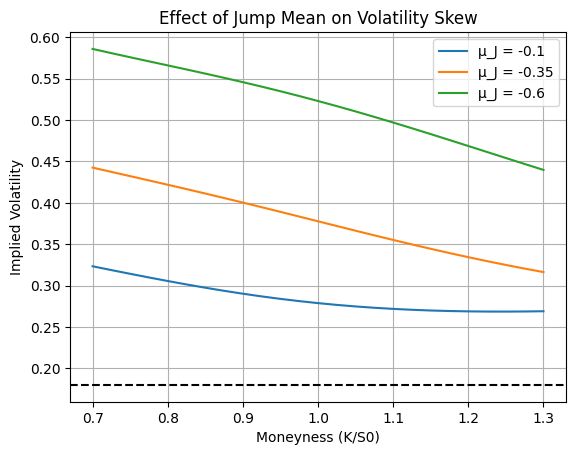

In [11]:
for muJ_test in [-0.1, -0.35, -0.6]:
    prices = [
        merton_option_price_formula(S0, K, r, T, sigma=sigma, lam=lam, mu_J=muJ_test, sigma_J=sigma_J, runs = 1000)
        for K in Ks
    ]
    ivs = [implied_vol(p, S0, K, r, T) for p, K in zip(prices, Ks)]
    plt.plot(Ks/S0, ivs, label=f"μ_J = {muJ_test}")
plt.axhline(sigma, linestyle="--", color="black")
plt.xlabel("Moneyness (K/S0)")
plt.ylabel("Implied Volatility")
plt.title("Effect of Jump Mean on Volatility Skew")
plt.legend()
plt.grid(True)
plt.show()


Decreasing the mean jump size amplifies the implied volatility skew by disproportionately increasing downside tail risk. More negative jumps raise the probability and severity of crash events, leading to sharply higher implied volatilities for low strikes while leaving the right tail relatively unaffected. This behavior mirrors the persistent left skew observed in equity index option markets and reflects the strong sensitivity of option prices to downside tail risk.